 **The Correlation between Well-Being and Freedom: an Empirical Perspective in the 21st Century**

by Francesca Negri (809625), Gianluca Licciardello (889935), Arnab Biswas (925349), Farabi Issa (922689)

*DATA SCIENCE LAB PROJECT A.Y. 2024/2025*

# **LIBRARIES**

In [4]:
from google.colab import drive
import pandas as pd
import os, warnings, contextlib, io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge

#!pip install pingouin
import pingouin as pg

import statsmodels.api as sm

#!pip install linearmodels
from linearmodels.panel import PanelOLS

from scipy.stats import combine_pvalues

#prediction
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# **GDRIVE CONNECTION**

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_path = '/content/drive/MyDrive/Data Science/Data science lab/project/DSLAB_files/'
os.listdir(base_path)

['ESGCSV.csv',
 'All_data_FIW_2013-2024.xlsx',
 'OECD-Regional-Well-Being-Data-File.xlsx',
 'Aggregate_Category_and_Subcategory_Scores_FIW_2003-2024.xlsx']

# **DATASETS LINK**


- Well Being (https://datacatalog.worldbank.org/search/dataset/0037651/Pollution--Social-and-Governance-Data)
- Dmocracy/Freedom (https://freedomhouse.org/report/freedom-world)

The goal is to understand if there’s a connection between an unhappy population and the raise of autoritarian politics.

# **ANALYSIS**


## **FREEDOM IN THE WORLD**


**Sheets**

- SHEET INDEX: Contains the legend for the columns in the other two sheets
- SHEET FIW06-24: Contains data from 2006 to 2024
- SHEET FIW03-05: COntains data from 2003 to 2005 (too old - no not use)

**Features**

- C/T? indicates whether the entry is a country (c) or territory (t)
- F = Free, PF = Partly Free, NF = Not Free
- PR Rating = Political Rights Rating
- CL Rating = Civil Liberties Rating
- A Aggr = aggregate score for the A. Electoral Process subcategory
- B Aggr = aggregate score for the B. Political Pluralism and Participation subcategory
- C Aggr = aggregate score for the C. Functioning of Government subcategory
- Add Q (Add B) = score for Additional Discretionary Question (B)
- Add A = score for Additional Discretionary Question A
- PR Aggr = aggregate score for the Political Rights category
- D Aggr = aggregate score for the D. Freedom of Expression and Belief subcategory
- E Aggr = aggregate score for the E. Associational and Organizational Rights subcategory
- F Aggr = aggregate score for the F. Rule of Law subcategory
- G Aggr = aggregate score for the G. Personal Autonomy and Individual Rights subcategory
- CL Aggr = aggregate score for the Civil Liberties categories
- Total Aggr = aggregate score for all categories

### IMPORT

In [7]:
# This was quite tricky because there are lots of file. I chose the one that's better for us, with the data already aggregated, but it's
# available even the most detailed one.

fw = base_path + 'Aggregate_Category_and_Subcategory_Scores_FIW_2003-2024.xlsx'
# Gian Farabi Arnab PLEASE NOTE!!! I manually removed an 'x' fromt the excel, in the AI column's first cell, to avoid importing many empty columns. If you
# download the dataset again, you'll have to do that - or to code another way around after.

# WHAT I DO IN THE NEXT LINES:
dff = pd.read_excel(fw,sheet_name='FIW06-24')
dff.rename(columns={'Region':'Continent','Country/Territory':'Country Name','Edition':'Year'},inplace=True) # to avoid confusion with other df in the next steps

In [8]:
dff

,Country Name,Continent,C/T?,Year,Status,PR Rating,CL Rating,A,B,C,Add Q,Add A,PR,D,E,F,G,CL,Total
0,Abkhazia,Eurasia,t,2024,PF,5,5,5,8,4,0,NaN,17,8,5,4,5,22,39
1,Afghanistan,Asia,c,2024,NF,7,7,0,0,1,0,NaN,1,0,3,0,2,5,6
2,Albania,Europe,c,2024,PF,3,3,9,12,7,0,NaN,28,13,8,10,9,40,68
3,Algeria,Africa,c,2024,NF,6,5,3,4,3,0,NaN,10,6,3,6,7,22,32
4,Andorra,Europe,c,2024,F,1,1,12,15,11,0,NaN,38,14,11,15,15,55,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,Vietnam,Asia,c,2006,NF,7,5,0,1,1,0,0.0,2,3,2,4,8,17,19
3965,Western Sahara,Africa,t,2006,NF,7,6,0,0,0,2,0.0,-2,3,2,0,5,10,8
3966,Yemen,Middle East,c,2006,PF,5,5,4,6,3,0,0.0,13,7,3,3,5,18,31
3967,Zambia,Africa,c,2006,PF,4,4,5,11,6,0,0.0,22,11,8,8,7,34,56


### HANDLING MISSING VALUES

In [9]:
print("\nFields with missing values (and how many):")
null_counts = dff.isnull().sum()
display(null_counts[null_counts > 0])


Fields with missing values (and how many):


,0
Add A,1468


##### "Add A" Imputation - and later removal


In [10]:
#values frequency check:
dff['Add A'].value_counts()

,count
Add A,
0.0,2432
3.0,27
1.0,17
2.0,17
4.0,8


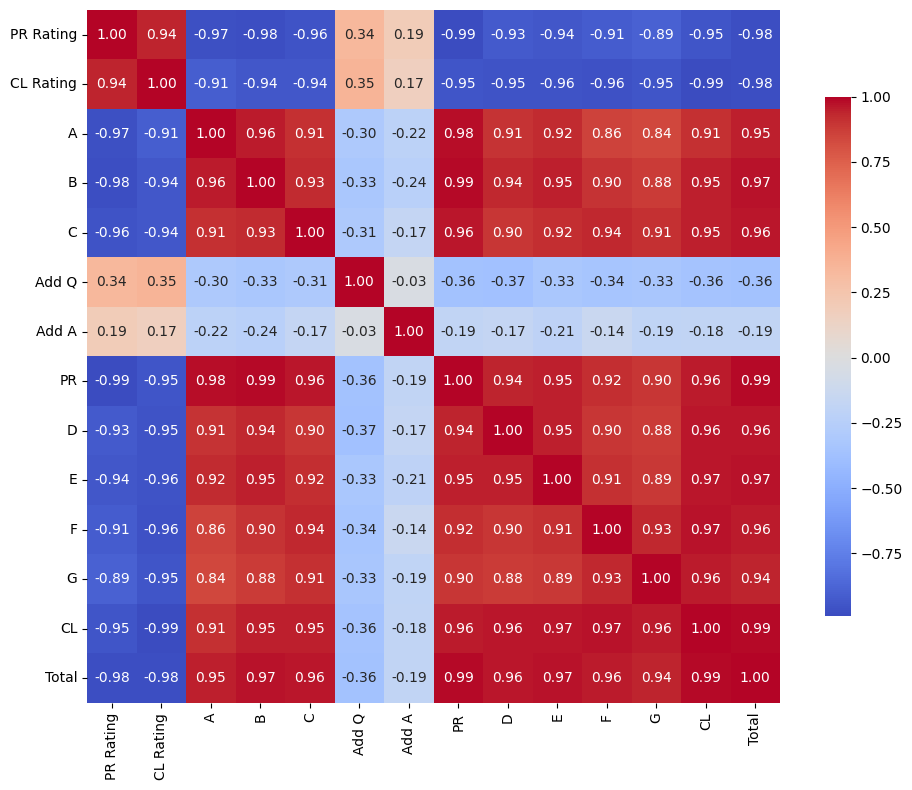

In [11]:
#correlation check:

indicators = ['PR Rating','CL Rating', 'A', 'B', 'C', 'Add Q', 'Add A', 'PR', 'D', 'E', 'F', 'G', 'CL', 'Total']
plt.figure(figsize=(10, 8))
corr = dff[indicators].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.tight_layout()
plt.show()

Most of the values are around >90% are zeros. Also Add A feature s nearly not correleted with other features, therefore we can simply impute it with the most frequent value (0 in our case).

In [12]:
dff

,Country Name,Continent,C/T?,Year,Status,PR Rating,CL Rating,A,B,C,Add Q,Add A,PR,D,E,F,G,CL,Total
0,Abkhazia,Eurasia,t,2024,PF,5,5,5,8,4,0,NaN,17,8,5,4,5,22,39
1,Afghanistan,Asia,c,2024,NF,7,7,0,0,1,0,NaN,1,0,3,0,2,5,6
2,Albania,Europe,c,2024,PF,3,3,9,12,7,0,NaN,28,13,8,10,9,40,68
3,Algeria,Africa,c,2024,NF,6,5,3,4,3,0,NaN,10,6,3,6,7,22,32
4,Andorra,Europe,c,2024,F,1,1,12,15,11,0,NaN,38,14,11,15,15,55,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,Vietnam,Asia,c,2006,NF,7,5,0,1,1,0,0.0,2,3,2,4,8,17,19
3965,Western Sahara,Africa,t,2006,NF,7,6,0,0,0,2,0.0,-2,3,2,0,5,10,8
3966,Yemen,Middle East,c,2006,PF,5,5,4,6,3,0,0.0,13,7,3,3,5,18,31
3967,Zambia,Africa,c,2006,PF,4,4,5,11,6,0,0.0,22,11,8,8,7,34,56


In [13]:
dff.drop(columns=['Add A'],inplace=True)

dff.columns

Index(['Country Name', 'Continent', 'C/T?', 'Year', 'Status', 'PR Rating',
       'CL Rating', 'A', 'B', 'C', 'Add Q', 'PR', 'D', 'E', 'F', 'G', 'CL',
       'Total'],
      dtype='object')

### DESCRIPTIVE STATISTICS FOR THE REPORT

In [14]:
desc_stats = dff.describe().T
desc_stats['missing_count'] = dff.isnull().sum()
desc_stats['missing_perc'] = dff.isnull().mean() * 100

desc_stats_rounded = desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_count', 'missing_perc']].round(2)

desc_stats_rounded

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_perc
Year,3969.0,2015.03,5.47,2006.0,2010.0,2015.0,2020.0,2024.0,0,0.0
PR Rating,3969.0,3.57,2.21,1.0,1.0,3.0,6.0,7.0,0,0.0
CL Rating,3969.0,3.41,1.92,1.0,2.0,3.0,5.0,7.0,0,0.0
A,3969.0,7.33,4.43,0.0,3.0,9.0,12.0,12.0,0,0.0
B,3969.0,9.62,5.37,0.0,5.0,11.0,15.0,16.0,0,0.0
C,3969.0,6.13,3.75,0.0,3.0,6.0,10.0,12.0,0,0.0
Add Q,3969.0,0.16,0.63,0.0,0.0,0.0,0.0,4.0,0,0.0
PR,3969.0,22.96,13.42,-3.0,11.0,26.0,36.0,40.0,0,0.0
D,3969.0,10.70,4.63,0.0,7.0,12.0,15.0,16.0,0,0.0
E,3969.0,7.38,3.93,0.0,4.0,8.0,11.0,12.0,0,0.0


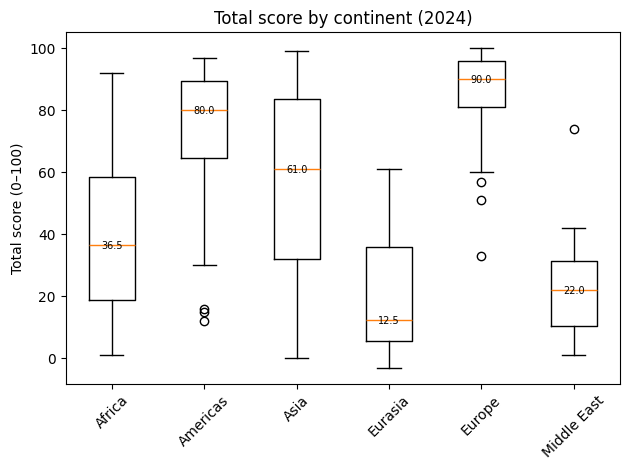

In [15]:
#BOXPLOT OF TOTAL AGGR BY CONTINENT - LATEST YEAR
year_latest = dff["Year"].max()
df_latest = dff[dff["Year"] == year_latest].copy()

cont_order = sorted(df_latest["Continent"].dropna().unique())
data_by_cont = [df_latest[df_latest["Continent"] == c]["Total"].values
                for c in cont_order if len(df_latest[df_latest["Continent"] == c]) > 0]

#plt.figure(figsize=(3.4, 3.8))  # ~\columnwidth in LaTeX
plt.boxplot(data_by_cont, tick_labels=[c for c in cont_order if len(df_latest[df_latest["Continent"] == c]) > 0])

medians = [np.median(vals) for vals in data_by_cont]
for i, median in enumerate(medians, start=1):
    plt.text(i, median - 2, f"{median:.1f}",  # +1 per alzare un po’ sopra la linea
             ha="center", va="bottom", fontsize=7, color="black")

plt.ylabel("Total score (0–100)")
plt.title(f"Total score by continent ({year_latest})")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("fiw_box_total_by_continent.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

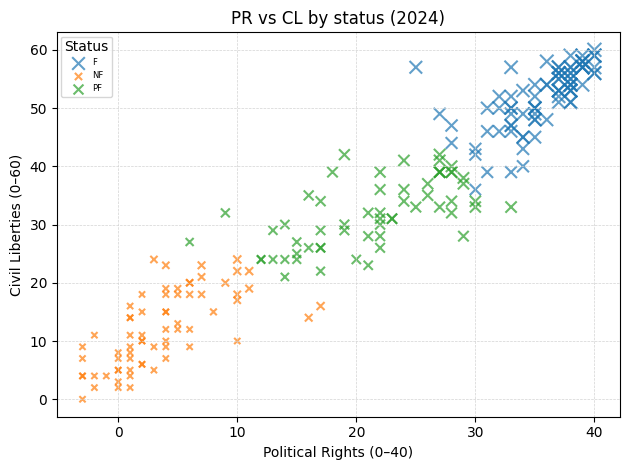

In [16]:
#SCATTERPLOT FREEDOM - LATEST YEAR
subset = df_latest.dropna(subset=["PR", "CL", "Total", "Status"]).copy()
statuses = sorted(subset["Status"].unique())

for s in statuses:
    part = subset[subset["Status"] == s]
    plt.scatter(part["PR"], part["CL"],
                s=np.clip(part["Total"], 20, 120),
                label=s, alpha=0.7,marker="x")
plt.xlabel("Political Rights (0–40)")
plt.ylabel("Civil Liberties (0–60)")
plt.title(f"PR vs CL by status ({year_latest})")
plt.legend(fontsize=6, title="Status", loc="best")
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)

plt.tight_layout()
#plt.savefig("fiw_scatter_pr_cl.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

Status unique: ['PF' 'NF' 'F']
Columns available: ['Country Name', 'Continent', 'C/T?', 'Year', 'Status', 'PR Rating', 'CL Rating', 'A', 'B', 'C', 'Add Q', 'PR', 'D', 'E', 'F']


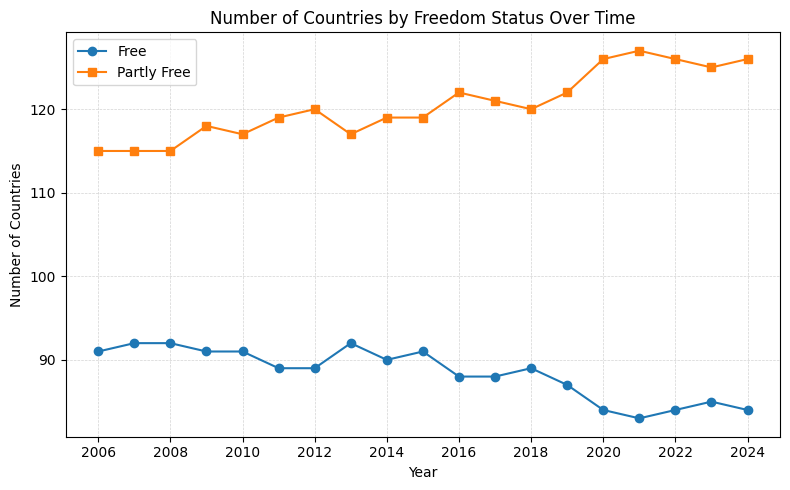

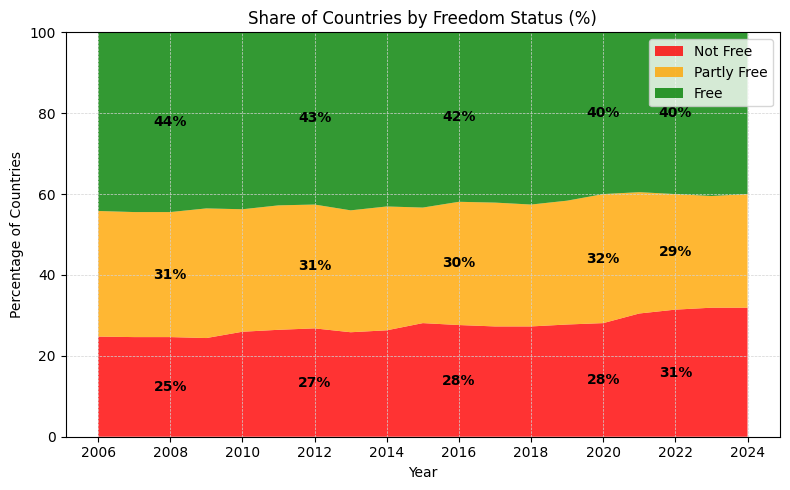

In [17]:
#OLD
"""
#TREND OF NF+PF over time
nf_countries = dff[dff['Status'] == 'NF'].groupby('Year').size()
pf_countries = dff[dff['Status'] == 'PF'].groupby('Year').size()
f_countries = dff[dff['Status'] == 'F'].groupby('Year').size()

combined_countries = nf_countries + pf_countries #+ f_countries #proof for total


plt.figure(figsize=(10, 6))
plt.plot(combined_countries.index, combined_countries.values, label='Countries (NF + PF)', color='purple')
#plt.plot(f_countries.index, f_countries.values, label='Countries F', color='orange')
plt.title('Number of Countries that are Not Free or Partially Free (NF + PF) Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
"""


#NEW

#Sanity check
print("Status unique:", dff['Status'].dropna().unique()[:10])
print("Columns available:", dff.columns.tolist()[:15])

#make the counts
df = dff[['Country Name', 'Year', 'Status']].dropna(subset=['Year', 'Status']).copy()
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

df = df[df['Status'].isin(['F', 'PF', 'NF'])].dropna(subset=['Year'])

counts = (df.groupby(['Year', 'Status'])['Country Name']
            .nunique()
            .unstack(fill_value=0)
            .reindex(columns=['F','PF','NF'], fill_value=0)
         )

#this for having all years in the range
all_years = range(int(counts.index.min()), int(counts.index.max())+1)
counts = counts.reindex(all_years, fill_value=0)

#chart
plt.figure(figsize=(8,5))
plt.plot(counts.index, counts['F'],  label='Free',         marker='o')
plt.plot(counts.index, counts['PF']+counts['NF'], label='Partly Free',  marker='s')
#plt.plot(counts.index, counts['NF'], label='Not Free',     marker='^')

plt.title('Number of Countries by Freedom Status Over Time')
plt.xlabel('Year'); plt.ylabel('Number of Countries')
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))  # ticks ogni 2 anni
plt.legend()
plt.tight_layout()
plt.show()



#BONUS using counts as above

counts_pct = counts[['NF','PF','F']].div(counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8,5))
ax.stackplot(counts_pct.index,
             counts_pct['NF'], counts_pct['PF'], counts_pct['F'],
             labels=['Not Free','Partly Free','Free'],
             colors=['red','orange','green'], alpha=0.8)

ax.set_title('Share of Countries by Freedom Status (%)')
ax.set_xlabel('Year'); ax.set_ylabel('Percentage of Countries')
ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
ax.set_ylim(0, 100)
ax.grid(color="lightgray", linestyle="--", linewidth=0.5)
ax.legend(loc='upper right')

#arbitary years choosing
label_years = [2008, 2012, 2016, 2020, 2022]
label_years = [y for y in label_years if y in counts_pct.index]  # sicurezza

for year in label_years:
    nf = counts_pct.loc[year, 'NF']
    pf = counts_pct.loc[year, 'PF']
    f  = counts_pct.loc[year, 'F']

    ax.text(year, nf/2,                f"{nf:.0f}%", ha='center', va='center', fontsize=10,fontweight='bold')
    ax.text(year, nf + pf/2,           f"{pf:.0f}%", ha='center', va='center', fontsize=10,fontweight='bold')
    ax.text(year, nf + pf + f/2,       f"{f:.0f}%",  ha='center', va='center', fontsize=10,fontweight='bold')

plt.tight_layout()
plt.show()

##### Downloading

In [18]:
dff.to_csv('dff_x.csv', index=False)

from google.colab import files
#files.download('dff_x.csv')

## **WELL BEING**

### IMPORT

In [19]:
wb = pd.read_csv(base_path + 'ESGCSV.csv', sep=',')
wb.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,86.705717,86.942778,87.228705,87.390856,87.617862,87.798740,87.948264,88.092536,NaN,NaN
1,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,88.832276,89.053852,89.539016,90.662754,89.176939,90.352802,90.635050,90.845661,NaN,NaN
2,Arab World,ARB,Adjusted savings: natural resources depletion ...,NY.ADJ.DRES.GN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,10.050554,6.130655,5.265859,6.245422,8.187714,7.234436,4.598506,NaN,NaN,NaN


### INITIAL RESHAPE

In [20]:
# 1 - initial reshape
years = [str(y) for y in range(2006, 2024)]
wb = wb[['Country Name', 'Country Code', 'Indicator Name'] + years]

missing_perc = wb[years].isnull().mean(axis=1)
wb = wb[missing_perc < 0.5]  # keeps only rows with NaNs <50%

# Melting and pivoting to have indictors as columns
wb_melted = pd.melt(wb, id_vars=['Country Name', 'Country Code', 'Indicator Name'],
                    value_vars=years,
                    var_name='Year', value_name='Value')

new_wb = wb_melted.pivot_table(index=['Country Name', 'Country Code', 'Year'],
                               columns='Indicator Name',
                               values='Value',
                               aggfunc='first').reset_index()

new_wb.head(3)

Indicator Name,Country Name,Country Code,Year,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Adjusted savings: natural resources depletion (% of GNI),Adjusted savings: net forest depletion (% of GNI),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)","Annual freshwater withdrawals, total (% of internal resources)",...,Research and development expenditure (% of GDP),Rule of Law: Estimate,"School enrollment, primary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Scientific and technical journal articles,Standardised Precipitation-Evapotranspiration Index,Tree Cover Loss (hectares),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Unmet need for contraception (% of married women ages 15-49),Voice and Accountability: Estimate
0,Afghanistan,AFG,2006,13.9,33.544418,NaN,NaN,58.123668,28.635969,43.015907,...,NaN,-1.879005,103.932243,0.57323,14.86,-0.381402,152.0,7.925,NaN,-1.110294
1,Afghanistan,AFG,2007,15.3,38.440002,NaN,NaN,58.129801,30.105011,43.015907,...,NaN,-1.852560,101.086456,0.56720,13.23,-0.358944,253.0,7.924,NaN,-1.057654
2,Afghanistan,AFG,2008,16.8,42.400000,NaN,NaN,58.132867,24.892270,43.015907,...,NaN,-1.903308,103.413963,0.58602,12.50,-1.388464,107.0,7.928,NaN,-1.168902


### FEATURE SELECTION

In [21]:
df_all_features = new_wb.copy()

#display(df_all_features)

# 2 - Feature Screening
missing = df_all_features.isnull().mean() #% of missing for each column

variance = df_all_features.var(numeric_only=True)

# Keeps cols with variance!=0 and with mising < 30%
filtered_features = [col for col in df_all_features.columns
                     if (missing[col] < 0.3) and (variance.get(col, 0) > 0)]

df_filtered = df_all_features[filtered_features].dropna()
#display(df_filtered)

# 3 - PCA / clustering

X = df_filtered[filtered_features]
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA()
pca.fit(X_scaled)

pca_features = pd.DataFrame(pca.components_.T, index=filtered_features,
                            columns=[f"PC{i+1}" for i in range(len(filtered_features))])



top_features = pca_features['PC1'].abs().sort_values(ascending=False).head(20)
print("Top 20 features from PC1:")
print(top_features)

Top 20 features from PC1:
Life expectancy at birth, total (years)                                 0.249707
Government Effectiveness: Estimate                                      0.249257
Individuals using the Internet (% of population)                        0.245459
Access to clean fuels and technologies for cooking (% of population)    0.240034
Regulatory Quality: Estimate                                            0.238010
Mortality rate, under-5 (per 1,000 live births)                         0.237599
Population ages 65 and above (% of total population)                    0.236845
Fertility rate, total (births per woman)                                0.236469
Rule of Law: Estimate                                                   0.235062
Agriculture, forestry, and fishing, value added (% of GDP)              0.230000
Control of Corruption: Estimate                                         0.226414
Access to electricity (% of population)                                 0.219819
Vo

A PCA-based feature importance ranking was used to guide the selection, and 6 of the final indicators emerged among the top contributors to the first principal component.

In [22]:
#We select the features of interest for the project

preferred_features = set([
    'Rule of Law: Estimate',
    'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Life expectancy at birth, total (years)',
    'Voice and Accountability: Estimate',
    'Individuals using the Internet (% of population)',
    'Government Effectiveness: Estimate'
])

# this below is an arbitrary list to complete the one above
extra_indicators = set([
    'School enrollment, primary (% gross)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Gini index',
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
])

selected_features = preferred_features.union(extra_indicators)

print("\nFinal selected features:\n")
for n,sc in enumerate(selected_features):
  print(n+1, sc)


Final selected features:

1 Life expectancy at birth, total (years)
2 PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)
3 Voice and Accountability: Estimate
4 Gini index
5 Unemployment, total (% of total labor force) (modeled ILO estimate)
6 Political Stability and Absence of Violence/Terrorism: Estimate
7 Individuals using the Internet (% of population)
8 School enrollment, primary (% gross)
9 Government Effectiveness: Estimate
10 Rule of Law: Estimate


In [23]:
keep_cols = ['Country Name', 'Country Code', 'Year'] + list(selected_features)
new_wb = new_wb[keep_cols].copy().reset_index(drop=True)

new_wb.columns, len(new_wb.columns)

(Index(['Country Name', 'Country Code', 'Year',
        'Life expectancy at birth, total (years)',
        'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
        'Voice and Accountability: Estimate', 'Gini index',
        'Unemployment, total (% of total labor force) (modeled ILO estimate)',
        'Political Stability and Absence of Violence/Terrorism: Estimate',
        'Individuals using the Internet (% of population)',
        'School enrollment, primary (% gross)',
        'Government Effectiveness: Estimate', 'Rule of Law: Estimate'],
       dtype='object', name='Indicator Name'),
 13)

In [24]:
new_wb.columns

Index(['Country Name', 'Country Code', 'Year',
       'Life expectancy at birth, total (years)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Voice and Accountability: Estimate', 'Gini index',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)',
       'Political Stability and Absence of Violence/Terrorism: Estimate',
       'Individuals using the Internet (% of population)',
       'School enrollment, primary (% gross)',
       'Government Effectiveness: Estimate', 'Rule of Law: Estimate'],
      dtype='object', name='Indicator Name')

### RENAMING

In [25]:
# Renaming the columns
#first draft: Digital Access was "Accessibility to services", Pollution was "Enrivonment", Confidence was "Safety", "Unemployment" was "Jobs", Life Expectancy was "Health"

new_names = {'Gini index' : 'Income',
             'Government Effectiveness: Estimate' : 'Community',
             'Individuals using the Internet (% of population)' : 'Digital Access',
             'Political Stability and Absence of Violence/Terrorism: Estimate' : 'Political Stability',
             'Life expectancy at birth, total (years)' : 'Life Expectancy',
             'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)' : 'Pollution',
             'Rule of Law: Estimate' : 'Confidence',
             'School enrollment, primary (% gross)' : 'Education',
             'Unemployment, total (% of total labor force) (modeled ILO estimate)' : 'Unemployment',
             'Voice and Accountability: Estimate' : 'Civic Engagement'}
new_wb.rename(columns=new_names,inplace=True)
new_wb.columns

Index(['Country Name', 'Country Code', 'Year', 'Life Expectancy', 'Pollution',
       'Civic Engagement', 'Income', 'Unemployment', 'Political Stability',
       'Digital Access', 'Education', 'Community', 'Confidence'],
      dtype='object', name='Indicator Name')

##### Downloading

In [26]:
new_wb.to_csv('new_wb.csv', index=False)

from google.colab import files
#files.download('new_wb.csv')

### DESCRIPTIVE STATISTICS

In [27]:
new_wb.columns

Index(['Country Name', 'Country Code', 'Year', 'Life Expectancy', 'Pollution',
       'Civic Engagement', 'Income', 'Unemployment', 'Political Stability',
       'Digital Access', 'Education', 'Community', 'Confidence'],
      dtype='object', name='Indicator Name')

In [28]:
import numpy as np

meta_cols = ['Country Name', 'Country Code', 'Year']
indicator_cols = [col for col in new_wb.columns if col not in meta_cols and col != 'index']
already_norm_cols = [col for col in indicator_cols if new_wb[col].min() < 0]
raw_cols = [col for col in indicator_cols if col not in already_norm_cols]

#display(indicator_cols, already_norm_cols, raw_cols)

desc_stats = new_wb[indicator_cols].describe().T
desc_stats['missing_count'] = new_wb[indicator_cols].isnull().sum()
desc_stats['missing_perc'] = new_wb[indicator_cols].isnull().mean() * 100

desc_stats_rounded = desc_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_count', 'missing_perc']].round(2)

desc_stats_rounded

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_perc
Indicator Name,,,,,,,,,,
Life Expectancy,3525.0,70.44,8.10,42.91,64.65,71.91,76.44,84.56,761,17.76
Pollution,2380.0,29.87,18.18,5.16,15.80,24.07,43.16,95.24,1906,44.47
Civic Engagement,3276.0,-0.05,1.00,-2.31,-0.89,0.00,0.85,1.77,1010,23.57
Income,955.0,35.64,7.72,23.20,29.50,34.30,40.20,57.50,3331,77.72
Unemployment,4030.0,7.55,5.28,0.10,4.08,6.06,9.48,36.39,256,5.97
Political Stability,3276.0,-0.07,0.99,-3.31,-0.69,0.01,0.78,1.67,1010,23.57
Digital Access,3712.0,42.94,30.04,0.18,14.99,39.81,70.32,100.00,574,13.39
Education,3245.0,101.94,11.44,44.18,97.92,101.34,106.32,151.73,1041,24.29
Community,3239.0,-0.08,0.99,-2.44,-0.78,-0.20,0.55,2.47,1047,24.43


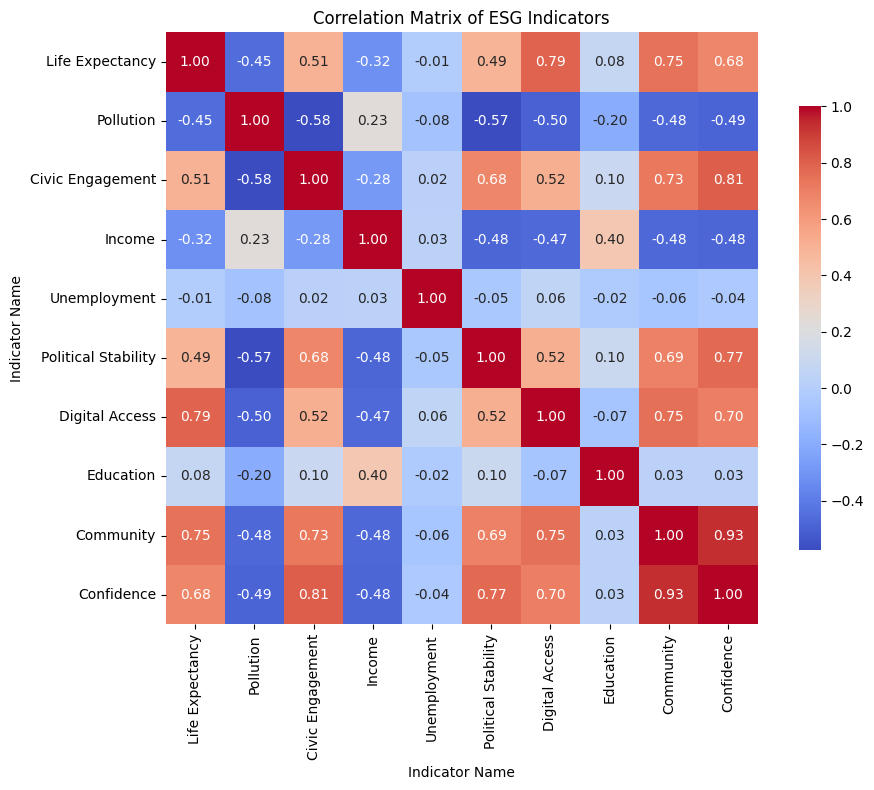

In [29]:
# 2. Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
corr = new_wb[indicator_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Matrix of ESG Indicators")
plt.tight_layout()
#plt.savefig("/mnt/data/correlation_matrix_esg.png", dpi=300)
plt.show()

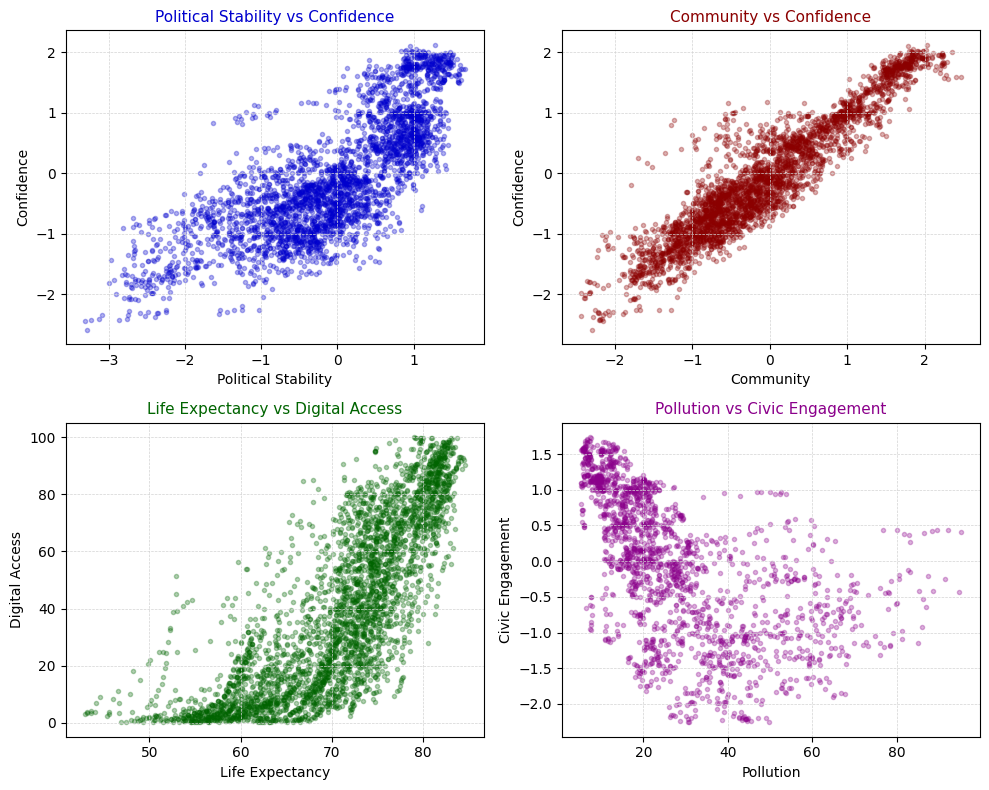

In [30]:
#focus on some of the strongest correlation:

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plots = [
    ("Political Stability", "Confidence"),
    ("Community", "Confidence"),
    ("Life Expectancy", "Digital Access"),
    ("Pollution", "Civic Engagement"),
]

colors = ["mediumblue", "darkred", "darkgreen", "darkmagenta"]  # un colore per ciascun plot

for ax, (X, Y), col in zip(axes.flat, plots, colors):
    subset = new_wb.dropna(subset=[X, Y])
    ax.scatter(subset[X], subset[Y],
               alpha=0.3, marker=".", color=col)
    ax.set_xlabel(X)
    ax.set_ylabel(Y)
    ax.set_title(f"{X} vs {Y}", fontsize=11, color=col)
    ax.grid(color="lightgray", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("wb_scatter_matrix_colored.png", dpi=300, bbox_inches="tight")
plt.show()

### HANDLING MISSING VALUES

In [31]:
print("\nFields with missing values (and how many):")
null_counts = new_wb.isnull().sum()
display(null_counts[null_counts > 0])


Fields with missing values (and how many):


,0
Indicator Name,
Life Expectancy,761
Pollution,1906
Civic Engagement,1010
Income,3331
Unemployment,256
Political Stability,1010
Digital Access,574
Education,1041
Community,1047


We impute Education and Unemployment  in two stages.

Linear interpolation by country – because each of these indicators evolves smoothly over time within the same country, we first fill any interior gaps by drawing straight lines between known values and then forward-/back-filling the remaining edge gaps.

Median back-fill – a few countries have all values missing, so interpolation can’t help. We replace those last NaNs with the global median for that series. Median imputation is more robust than using the mean, since it isn’t pulled toward extreme outliers.



In [32]:
#linear interpolation

new_wb.sort_values(['Country Name','Year'], inplace=True)
for col in ['Education','Unemployment']:
    new_wb.loc[:, col] = (
        new_wb
        .groupby('Country Name')[col]
        .transform(lambda x: x.interpolate(method='linear').ffill().bfill())
    )

In [33]:
#median back-fill

for col in ['Education','Unemployment']:
    median = new_wb[col].median()
    new_wb.loc[:, col] = new_wb[col].fillna(median)

In [34]:
print("\nFields with missing values (and how many):")
null_counts = new_wb.isnull().sum()
display(null_counts[null_counts > 0])


Fields with missing values (and how many):


,0
Indicator Name,
Life Expectancy,761
Pollution,1906
Civic Engagement,1010
Income,3331
Political Stability,1010
Digital Access,574
Community,1047
Confidence,1012


KNN imputer for highly coorelated features

In [35]:
knn_cols = [
    'Community',
    'Digital Access',
    'Life Expectancy',
    'Political Stability',
    'Confidence',
    'Civic Engagement',
]
knn_imp = KNNImputer(n_neighbors=5)
new_wb[knn_cols] = knn_imp.fit_transform(new_wb[knn_cols])

In [36]:
print("\nFields with missing values (and how many):")
null_counts = new_wb.isnull().sum()
display(null_counts[null_counts > 0])


Fields with missing values (and how many):


,0
Indicator Name,
Pollution,1906
Income,3331


Income and Pollution have very high missing rates (≈64 % and ≈44 %, respectively). Because they’re meaningfully correlated with other indicators, we use the MICE (iterative) imputation approach. MICE fits a multivariate regression for each variable in turn, iteratively predicting its missing values and converging to a stable solution. Once the raw series are complete, we then rescale them (and only them) to a 0–10 range to produce Income normalized and Pollution normalized.

In [37]:
iter_cols = ['Income', 'Pollution']
temp = new_wb[iter_cols].copy()
mice_imp = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0
)

imputed = mice_imp.fit_transform(temp)
new_wb.loc[:, iter_cols] = imputed

In [38]:
print("\nFields with missing values (and how many):")
null_counts = new_wb.isnull().sum()
display(null_counts[null_counts > 0])


Fields with missing values (and how many):


,0
Indicator Name,


### DEFINITIVE NORMALIZATION

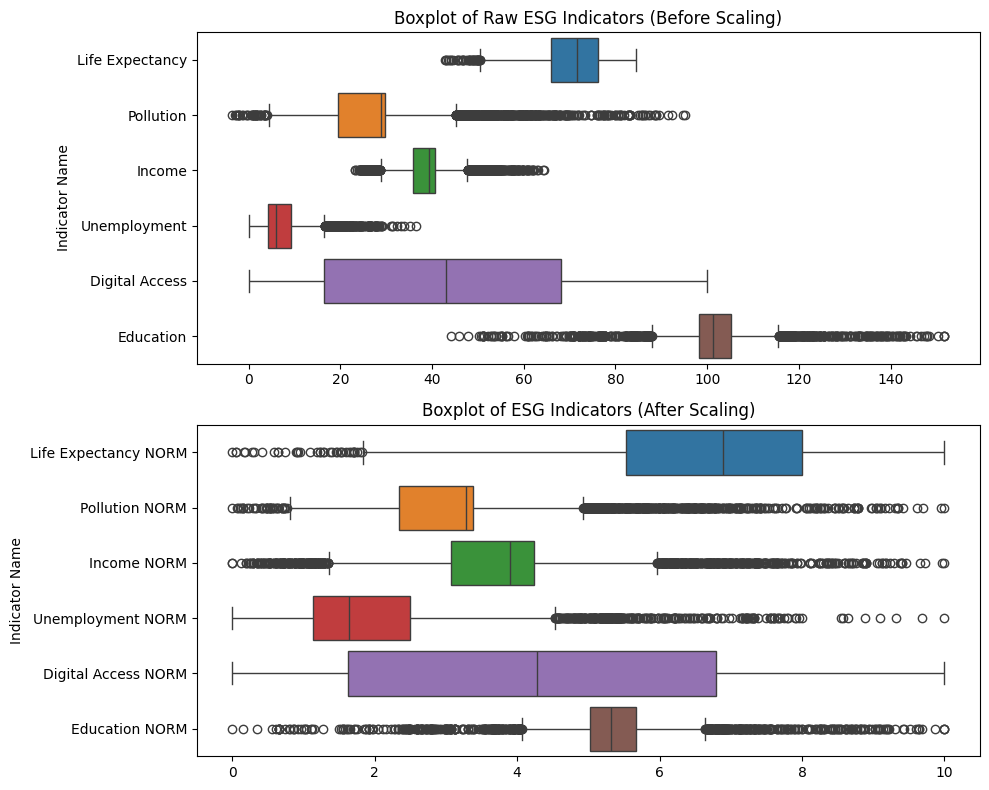

In [39]:
# Apply Min-Max scaling (range 0 to 10)
scaler = MinMaxScaler(feature_range=(0, 10))
normalized_values = scaler.fit_transform(new_wb[raw_cols])


# Add normalized values to the DataFrame with 'NORM' suffix
for col_name, norm_data in zip(raw_cols, normalized_values.T):
    new_wb[f"{col_name} NORM"] = norm_data

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 righe, no sharex

# Boxplot raw
sns.boxplot(data=new_wb[raw_cols], orient='h', ax=axes[0])
axes[0].set_title("Boxplot of Raw ESG Indicators (Before Scaling)")

# Boxplot standardized

normalized_cols = [f"{col} NORM" for col in raw_cols]

sns.boxplot(data=new_wb[normalized_cols], orient='h', ax=axes[1])
axes[1].set_title("Boxplot of ESG Indicators (After Scaling)")

plt.tight_layout()
plt.show()

In [40]:
print("Columns normalized:", raw_cols)
print("Normalized columns added:", normalized_cols)

Columns normalized: ['Life Expectancy', 'Pollution', 'Income', 'Unemployment', 'Digital Access', 'Education']
Normalized columns added: ['Life Expectancy NORM', 'Pollution NORM', 'Income NORM', 'Unemployment NORM', 'Digital Access NORM', 'Education NORM']


## **COUNTRIES FILTERING ACROSS DFF AND WB**

In [41]:
# Matching countries' name
new_names = {'Czechia' : 'Czech Republic',
             'Korea, Dem. People\'s Rep.' : 'North Korea',
             'Slovak Republic' : 'Slovakia',
             'Korea, Rep.' : 'South Korea',
             'Venezuela, RB' : 'Venezuela',
             'Brunei Darussalam' : 'Brunei',
             'Egypt, Arab Rep.' : 'Egypt',
             'Iran, Islamic Rep.' : 'Iran',
             'Kyrgyz Republic' : 'Kyrgyzstan',
             'Lao PDR' : 'Laos',
             'Bahamas, The' : 'Bahamas',
             'Micronesia, Fed. Sts.' : 'Micronesia',
             'Syrian Arab Republic' : 'Syria',
             'Turkiye' : 'Turkey',
             'Viet Nam' : 'Vietnam',
             'Russian Federation' : 'Russia',
             'Yemen, Rep.' : 'Yemen',
             'Congo, Rep.' : 'Congo (Brazzaville)',
             'Congo, Dem. Rep.' : 'Congo (Kinshasa)',
             'Gambia, The' : 'The Gambia'}

new_wb['Country Name'] = new_wb['Country Name'].replace(new_names)

In [42]:
len(new_wb['Country Name'].unique()), len(dff['Country Name'].unique())

(239, 215)

In [43]:
#Keeping only rows with countries in common across the 2 datasets
new_wb = new_wb[new_wb['Country Name'].isin(dff['Country Name'].unique().tolist())]
dff = dff[dff['Country Name'].isin(new_wb['Country Name'].unique().tolist())]

len(new_wb['Country Name'].unique()), len(dff['Country Name'].unique())

(193, 193)

## **MERGED DATASET**

- Freedom dataframe: dff
- Well Being dataframe: new_wb

In [44]:
new_wb.columns

Index(['Country Name', 'Country Code', 'Year', 'Life Expectancy', 'Pollution',
       'Civic Engagement', 'Income', 'Unemployment', 'Political Stability',
       'Digital Access', 'Education', 'Community', 'Confidence',
       'Life Expectancy NORM', 'Pollution NORM', 'Income NORM',
       'Unemployment NORM', 'Digital Access NORM', 'Education NORM'],
      dtype='object', name='Indicator Name')

In [45]:
dff.columns

Index(['Country Name', 'Continent', 'C/T?', 'Year', 'Status', 'PR Rating',
       'CL Rating', 'A', 'B', 'C', 'Add Q', 'PR', 'D', 'E', 'F', 'G', 'CL',
       'Total'],
      dtype='object')

In [46]:
new_wb['Country Name'] = new_wb['Country Name'].astype(str)
new_wb['Year'] = new_wb['Year'].astype(str)
dff = dff.copy().reset_index(drop=True)

dff['Country Name'] = dff['Country Name'].astype(str)
dff['Year'] = dff['Year'].astype(str)
merged = pd.merge(dff, new_wb[['Country Name', 'Country Code', 'Year', 'Digital Access NORM', 'Education NORM',
                               'Pollution NORM', 'Life Expectancy NORM', 'Income NORM', 'Unemployment NORM',
                               'Civic Engagement', 'Community', 'Political Stability','Confidence']],
                                on=['Country Name', 'Year'], how='inner')
merged

,Country Name,Continent,C/T?,Year,Status,PR Rating,CL Rating,A,B,C,...,Digital Access NORM,Education NORM,Pollution NORM,Life Expectancy NORM,Income NORM,Unemployment NORM,Civic Engagement,Community,Political Stability,Confidence
0,Afghanistan,Asia,c,2023,NF,7,7,0,0,1,...,4.283264,6.120785,3.287016,6.608768,3.900232,4.209975,-0.050818,-0.083576,-0.069200,-0.077634
1,Albania,Europe,c,2023,PF,3,3,9,12,7,...,4.283264,4.781731,3.287016,6.608768,3.900232,3.026454,-0.050818,-0.083576,-0.069200,-0.077634
2,Algeria,Africa,c,2023,NF,6,5,3,4,3,...,4.283264,5.966098,3.287016,6.608768,3.900232,3.348030,-0.050818,-0.083576,-0.069200,-0.077634
3,Angola,Africa,c,2023,NF,6,5,3,5,2,...,4.283264,5.315240,3.287016,6.608768,3.900232,3.891706,-0.050818,-0.083576,-0.069200,-0.077634
4,Argentina,Americas,c,2023,F,2,2,11,16,8,...,4.283264,6.134603,3.287016,6.608768,3.900232,1.857537,-0.050818,-0.083576,-0.069200,-0.077634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,Venezuela,Americas,c,2006,PF,4,4,10,8,5,...,1.507010,5.440678,3.287016,7.162272,3.900232,2.344999,-0.622201,-1.066524,-1.252868,-1.409444
3446,Vietnam,Asia,c,2006,NF,7,5,0,1,1,...,1.710365,5.354738,3.287016,7.300821,3.900232,0.535960,-1.538451,-0.246990,0.405120,-0.518899
3447,Yemen,Middle East,c,2006,PF,5,5,4,6,3,...,0.106772,5.315240,3.287016,5.540508,3.900232,3.376963,-1.187120,-0.920007,-1.345312,-1.039284
3448,Zambia,Africa,c,2006,PF,4,4,5,11,6,...,0.142054,6.605701,3.287016,2.132498,3.900232,3.616699,-0.207338,-0.877599,0.363792,-0.549667


**FREEDOM AND DEMOCRACY**

- C/T? indicates whether the entry is a country (c) or territory (t)
- Status: F = Free, PF = Partly Free, NF = Not Free
- PR Rating = Political Rights Rating
- CL Rating = Civil Liberties Rating
- A Aggr = aggregate score for the A. Electoral Process subcategory
- B Aggr = aggregate score for the B. Political Pluralism and Participation subcategory
- C Aggr = aggregate score for the C. Functioning of Government subcategory
- Add Q (Add B) = score for Additional Discretionary Question (B)
- Add A = score for Additional Discretionary Question A
- PR Aggr = aggregate score for the Political Rights category
- D Aggr = aggregate score for the D. Freedom of Expression and Belief subcategory
- E Aggr = aggregate score for the E. Associational and Organizational Rights subcategory
- F Aggr = aggregate score for the F. Rule of Law subcategory
- G Aggr = aggregate score for the G. Personal Autonomy and Individual Rights subcategory
- CL Aggr = aggregate score for the Civil Liberties categories
- Total Aggr = aggregate score for all categories

**WELL-BEING**

- Education: gross enrollment ratio is the ratio of total enrollment.
- Unemployment : refers to the share of the labor force that is without work but available for and seeking employment.
- Income: measures the extent to which the distribution of income.
- Confidence: captures perceptions of the extent to which agents have confidence in and abide by the rules of society.
- Political Stability: measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism..
- Life Expectancy: life expectancy at birth.
- Pollution: PM2.5 air pollution, mean annual exposure (micrograms per cubic meter).
- Civic Engagement: captures perceptions of the extent to which a Country Name's citizens are able to participate in selecting their government, as well as freedom of expression, freedom of association, and a free media.
- Digital Access: individuals using the Internet (% of population).
- Community: captures perceptions of the quality of public services, the quality of the civil service and the degree of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the government's commitment to such policies.

In [47]:
merged.columns

Index(['Country Name', 'Continent', 'C/T?', 'Year', 'Status', 'PR Rating',
       'CL Rating', 'A', 'B', 'C', 'Add Q', 'PR', 'D', 'E', 'F', 'G', 'CL',
       'Total', 'Country Code', 'Digital Access NORM', 'Education NORM',
       'Pollution NORM', 'Life Expectancy NORM', 'Income NORM',
       'Unemployment NORM', 'Civic Engagement', 'Community',
       'Political Stability', 'Confidence'],
      dtype='object')

##### Downloading

In [48]:
merged.to_csv('merged.csv', index=False)

from google.colab import files
#files.download('merged.csv')

### WB index

Here the WB index is created as the mean of the chosen features

In [49]:
#wrong version -> you didn't consider that some fields are 'reversed' (high is worse)
#and the shifting (that I removed bc it was redundant) didn't resolve the wrong scaling between normalized and standardized values -FN

merged['WB index'] = merged[['Pollution NORM', 'Life Expectancy NORM', 'Income NORM', 'Unemployment NORM',
                                    'Civic Engagement', 'Community',
                                    'Political Stability', 'Confidence']].mean(axis=1)
merged['WB index'].describe()

,WB index
count,3450.000000
mean,1.933246
std,0.570337
min,0.284949
25%,1.526196
50%,1.932940
75%,2.381567
max,3.654101


In [50]:
#correct version -FN

#this is a copy to avoid touching original values
wb_block = merged[['Pollution NORM', 'Life Expectancy NORM', 'Income NORM',
                   'Unemployment NORM', 'Civic Engagement', 'Community',
                   'Political Stability', 'Confidence']].copy().reset_index(drop=True)

#invert reverted fields (so high is actually better)
wb_block['Pollution NORM']     = 10 - wb_block['Pollution NORM']
wb_block['Unemployment NORM']  = 10 - wb_block['Unemployment NORM']
wb_block['Income NORM']        = 10 - wb_block['Income NORM']

#temporary rescaling of stded values to normalization 0-10
def rescale_to_0_10(series):
    return (series - series.min()) / (series.max() - series.min()) * 10

for col in ['Civic Engagement', 'Community', 'Political Stability', 'Confidence']:
    wb_block[col] = rescale_to_0_10(wb_block[col])

#now, only now, the index
merged['WB index'] = wb_block.mean(axis=1, skipna=True)

merged['WB index'].describe()

,WB index
count,3450.000000
mean,6.234491
std,1.355149
min,2.634993
25%,5.311640
50%,6.176626
75%,7.181964
max,9.295087


those numbers have much more sense since they are actually 0-10 with a mean of 6.2

just see the mean of the 2 datasets to see it makes sense -FN

#### Well-being indeces changes between 2006 and 2023 - not in report

Comparison and difference between start and end of range

In [51]:
# Columns of interest
cols_of_interest = [
    'Digital Access NORM', 'Education NORM',
    'Pollution NORM', 'Life Expectancy NORM',
    'Income NORM', 'Unemployment NORM',
    'Civic Engagement', 'Community',
    'Political Stability', 'Confidence',
    'WB index'
]

df_2006 = merged[merged['Year'] == '2006']
df_2023 = merged[merged['Year'] == '2023']


median_2006 = df_2006[cols_of_interest].median()
median_2023 = df_2023[cols_of_interest].median()


absolute_change = median_2023 - median_2006
percentage_change = (absolute_change / median_2006.replace(0, np.nan)) * 100

result_df = pd.DataFrame({
    'Median in 2006': median_2006,
    'Median in 2023': median_2023,
    'Absolute Change': absolute_change,
    'Percentage Change': percentage_change
})

display(result_df.round(3))

,Median in 2006,Median in 2023,Absolute Change,Percentage Change
Digital Access NORM,1.199,4.283,3.084,257.140
Education NORM,5.340,5.315,-0.025,-0.467
Pollution NORM,3.287,3.287,0.000,0.000
Life Expectancy NORM,6.762,6.609,-0.153,-2.264
Income NORM,3.900,3.900,0.000,0.000
Unemployment NORM,1.642,1.424,-0.218,-13.289
Civic Engagement,-0.007,-0.051,-0.044,671.351
Community,-0.244,-0.084,0.160,-65.678
Political Stability,0.027,-0.069,-0.096,-359.048
Confidence,-0.283,-0.078,0.206,-72.587


### VISUAL CORRELATION

#### Correlation analysis between WB index and Total score for freedom and democracy

As expected seems to be correlation between the two features. Note that year 2023 has a very strange distribution. Further analyses on the impuation process need to be done

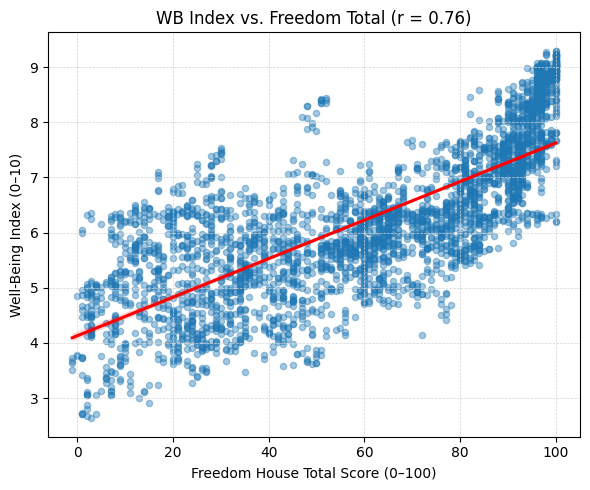

In [52]:
wb_tot_cor = merged['WB index'].corr(merged['Total'])

plt.figure(figsize=(6,5))
sns.regplot(data=merged, x="Total", y="WB index",
            scatter_kws={'alpha':0.4, 's':20}, line_kws={'color':'red'})
plt.title(f"WB Index vs. Freedom Total (r = {wb_tot_cor:.2f})")
plt.xlabel("Freedom House Total Score (0–100)")
plt.ylabel("Well-Being Index (0–10)")
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

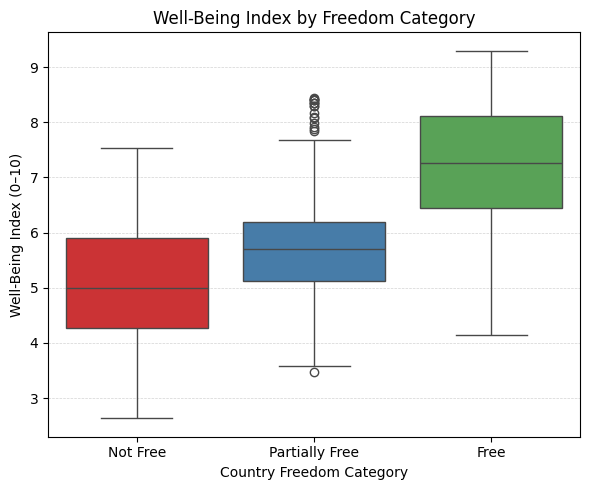

In [53]:
#BOXPLOT FREEDOM/WBI

bins = [0, 30, 70, 100]
labels = ["Not Free", "Partially Free", "Free"]
merged["FW Category"] = pd.cut(merged["Total"], bins=bins, labels=labels)

plt.figure(figsize=(6,5))
sns.boxplot(
    data=merged,
    x="FW Category", y="WB index", hue="FW Category", palette="Set1", legend=False)
plt.title("Well-Being Index by Freedom Category")
plt.ylabel("Well-Being Index (0–10)")
plt.xlabel("Country Freedom Category")
plt.grid(axis="y", color="lightgray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# **INFERENTIAL STATISTICS**

### Pearson & Spearman

In [54]:
wb_tot_cor

np.float64(0.7612916279629642)

In [55]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation
pearson_corr, pearson_p = pearsonr(merged['WB index'], merged['Total'])
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3e}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(merged['WB index'], merged['Total'])
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3e}")


Pearson correlation: 0.761, p-value: 0.000e+00
Spearman correlation: 0.790, p-value: 0.000e+00


### Kendall's Tau

In [56]:
from scipy.stats import kendalltau

# Kendall tau correlation
tau, tau_p = kendalltau(merged['WB index'], merged['Total'])
print(f"Kendall tau: {tau:.3f}, p-value: {tau_p:.3e}")

Kendall tau: 0.607, p-value: 0.000e+00


### Partial correlations

In [57]:
#Life Expectancy - random selection
partial_corr = pg.partial_corr(data=merged,
                               x='WB index',
                               y='Total',
                               covar='Life Expectancy NORM',
                               method='pearson')
print(partial_corr)

            n         r        CI95%  p-val
pearson  3450  0.719025  [0.7, 0.73]    0.0


In [58]:
#every covariates

targets = ('WB index', 'Total')  # X , Y

controls = [
    'Education NORM', 'Life Expectancy NORM', 'Digital Access NORM',
    'Income NORM', 'Unemployment NORM', 'Pollution NORM',
    'Civic Engagement', 'Community', 'Political Stability', 'Confidence'
]

# --- TRY with pingouin; fall back to residualization if not available ---
try:
    import pingouin as pg
    use_pg = True
except ImportError:
    import statsmodels.api as sm
    from scipy.stats import pearsonr
    use_pg = False

rows = []
for z in controls:
    # drop rows with missing in the trio (X, Y, Z)
    df = merged[[targets[0], targets[1], z]].dropna().copy()
    n = len(df)

    if n < 10:  # troppo poco per un test
        rows.append({'control': z, 'n': n, 'r_partial': np.nan, 'pval': np.nan})
        continue

    if use_pg:
        pc = pg.partial_corr(data=df, x=targets[0], y=targets[1], covar=z, method='pearson')
        rows.append({
            'control': z,
            'n': int(pc['n'].iloc[0]),
            'r_partial': float(pc['r'].iloc[0]),
            'pval': float(pc['p-val'].iloc[0]),
            'ci95': pc['CI95%'].iloc[0]
        })
    else:
        # residualize X and Y on Z, then Pearson on residuals
        Z = sm.add_constant(df[[z]])
        res_x = df[targets[0]] - sm.OLS(df[targets[0]], Z).fit().fittedvalues
        res_y = df[targets[1]] - sm.OLS(df[targets[1]], Z).fit().fittedvalues
        r, p = pearsonr(res_x, res_y)
        rows.append({'control': z, 'n': n, 'r_partial': r, 'pval': p})

partial_table = pd.DataFrame(rows).sort_values('r_partial', ascending=False).reset_index(drop=True)

try:
    from statsmodels.stats.multitest import multipletests
    m = partial_table['pval'].values
    ok = np.isfinite(m)
    _, p_fdr, _, _ = multipletests(m[ok], method='fdr_bh')
    partial_table.loc[ok, 'pval_FDR'] = p_fdr
except Exception:
    pass


partial_table.round(3)


,control,n,r_partial,pval,ci95,pval_FDR
0,Unemployment NORM,3450,0.775,0.0,"[0.76, 0.79]",0.0
1,Education NORM,3450,0.759,0.0,"[0.74, 0.77]",0.0
2,Income NORM,3450,0.743,0.0,"[0.73, 0.76]",0.0
3,Life Expectancy NORM,3450,0.719,0.0,"[0.7, 0.73]",0.0
4,Digital Access NORM,3450,0.713,0.0,"[0.7, 0.73]",0.0
5,Pollution NORM,3450,0.707,0.0,"[0.69, 0.72]",0.0
6,Political Stability,3450,0.540,0.0,"[0.52, 0.56]",0.0
7,Community,3450,0.540,0.0,"[0.52, 0.56]",0.0
8,Confidence,3450,0.356,0.0,"[0.33, 0.38]",0.0
9,Civic Engagement,3450,-0.173,0.0,"[-0.2, -0.14]",0.0


### OLS Regression

In [59]:
X = merged['Total']
y = merged['WB index']

X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               WB index   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4753.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:00:16   Log-Likelihood:                -4448.7
No. Observations:                3450   AIC:                             8901.
Df Residuals:                    3448   BIC:                             8914.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1303      0.034    121.515      0.0

In [60]:
ols_robust = sm.OLS(y, X).fit(cov_type='HC3')
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:               WB index   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     4156.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:00:16   Log-Likelihood:                -4448.7
No. Observations:                3450   AIC:                             8901.
Df Residuals:                    3448   BIC:                             8914.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1303      0.038    109.217      0.0

In [61]:
merged['Year'] = merged['Year'].astype(int)

panel = merged.set_index(['Country Name','Year']).sort_index()
Y = panel['WB index']
X = sm.add_constant(panel[['Total']])

fe = PanelOLS(Y, X, entity_effects=True, time_effects=True).fit(
        cov_type='clustered', cluster_entity=True)
print(fe.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               WB index   R-squared:                        0.0101
Estimator:                   PanelOLS   R-squared (Between):              0.2546
No. Observations:                3450   R-squared (Within):               0.0038
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.2312
Time:                        09:00:16   Log-likelihood                   -1780.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      32.901
Entities:                         193   P-value                           0.0000
Avg Obs:                       17.876   Distribution:                  F(1,3239)
Min Obs:                       12.000                                           
Max Obs:                       18.000   F-statistic (robust):             8.2068
                            

# **PREDICTING MODELS**

## Linear regression


### Train until 2019, predicting 2020-2023

In [62]:
TARGET = "WB index"
FEATURE_COLS = ["Total"]
TRAIN_END_YEAR = 2019
TEST_START_YEAR = 2020
OUTPUT_CSV = f"pred_wb_{TEST_START_YEAR}_2023.csv"
PREVIEW_ROWS = 10

if TARGET not in merged.columns:
    wb_norm = [
        "Digital Access NORM", "Education NORM", "Pollution NORM",
        "Life Expectancy NORM", "Income NORM", "Unemployment NORM"
    ]
    gov_raw = ["Civic Engagement", "Community", "Political Stability", "Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

need = ["Country Name", "Year"] + FEATURE_COLS + [TARGET]
data = merged[need].dropna().copy().sort_values(["Country Name", "Year"])
train = data[data["Year"] <= TRAIN_END_YEAR].copy()
test = data[data["Year"] >= TEST_START_YEAR].copy()

X_train = train[FEATURE_COLS].values
y_train = train[TARGET].values
X_test = test[FEATURE_COLS].values
y_test = test[TARGET].values

model = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
r2 = r2_score(y_test, y_pred)

out = test.copy()
out["WB_pred"] = y_pred
out["abs_err"] = (out["WB_pred"] - out[TARGET]).abs()
out = out.sort_values(["Year", "Country Name"]).reset_index(drop=True)
out.to_csv(OUTPUT_CSV, index=False)

print("=== MODELLO PREDITTIVO (batch) ===")
print(f"Train: <= {TRAIN_END_YEAR}  |  Test: >= {TEST_START_YEAR}")
print(f"Features: {FEATURE_COLS}  |  Target: {TARGET}")
print(f"Test RMSE: {rmse:.3f}  |  Test R^2: {r2:.3f}")
print(f"CSV predizioni salvato in: {OUTPUT_CSV}")
print(out.head(PREVIEW_ROWS))

=== MODELLO PREDITTIVO (batch) ===
Train: <= 2019  |  Test: >= 2020
Features: ['Total']  |  Target: WB index
Test RMSE: 0.909  |  Test R^2: 0.307
CSV predizioni salvato in: pred_wb_2020_2023.csv
          Country Name  Year  Total  WB index   WB_pred   abs_err
0          Afghanistan  2020     27  3.985524  4.927470  0.941946
1              Albania  2020     67  6.191784  6.454881  0.263097
2              Algeria  2020     34  5.261255  5.194767  0.066488
3              Andorra  2020     94  8.293692  7.485884  0.807809
4               Angola  2020     32  4.734428  5.118396  0.383969
5  Antigua and Barbuda  2020     85  7.087596  7.142216  0.054621
6            Argentina  2020     85  6.067311  7.142216  1.074905
7              Armenia  2020     53  6.673807  5.920287  0.753520
8            Australia  2020     97  8.129901  7.600440  0.529461
9              Austria  2020     93  8.735202  7.447698  1.287504


## Polynomial Regression

### Train until 2019, predicting 2020-2023

In [63]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

TARGET = "WB index"
NUMERIC_FEATURES = ["Total", "Year"]
CAT_FEATURES = ["Continent"]
DEGREE = 3
TRAIN_END_YEAR = 2019
TEST_START_YEAR = 2020
OUTPUT_CSV = f"pred_wb_{TEST_START_YEAR}_2023.csv"
PREVIEW_ROWS = 10

if TARGET not in merged.columns:
    wb_norm = ["Digital Access NORM","Education NORM","Pollution NORM","Life Expectancy NORM","Income NORM","Unemployment NORM"]
    gov_raw = ["Civic Engagement","Community","Political Stability","Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

merged["Year"] = merged["Year"].astype(int)
need = ["Country Name","Year","Continent",TARGET] + NUMERIC_FEATURES
need = list(dict.fromkeys(need))
data = merged[need].dropna().copy()

train = data[data["Year"] <= TRAIN_END_YEAR].copy()
test = data[data["Year"] >= TEST_START_YEAR].copy()

X_train = train[NUMERIC_FEATURES + CAT_FEATURES]
y_train = train[TARGET].values
X_test = test[NUMERIC_FEATURES + CAT_FEATURES]
y_test = test[TARGET].values

numeric_transformer = Pipeline([
    ("poly", PolynomialFeatures(degree=DEGREE, include_bias=False)),
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer([
    ("num", numeric_transformer, NUMERIC_FEATURES),
    ("cat", categorical_transformer, CAT_FEATURES)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("reg", ElasticNetCV(
        l1_ratio=[0.1,0.5,0.9,0.95,1.0],
        alphas=np.logspace(-4, 1, 80),
        cv=5,
        max_iter=200000,
        n_jobs=-1,
        random_state=42
    ))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
alpha_ = float(model.named_steps["reg"].alpha_)
l1r_ = float(model.named_steps["reg"].l1_ratio_)

out = test.copy()
out["WB_pred"] = y_pred
out["abs_err"] = (out["WB_pred"] - out[TARGET]).abs()
out = out.sort_values(["Year","Country Name"]).reset_index(drop=True)
out.to_csv(OUTPUT_CSV, index=False)

print("=== MODELLO PREDITTIVO (batch) ===")
print(f"Train: <= {TRAIN_END_YEAR}  |  Test: >= {TEST_START_YEAR}")
print(f"Features: {NUMERIC_FEATURES + CAT_FEATURES}  |  Target: {TARGET}  |  Degree: {DEGREE}")
print(f"ElasticNetCV alpha: {alpha_:.6f}  |  l1_ratio: {l1r_:.2f}")
print(f"Test RMSE: {rmse:.3f}  |  MAE: {mae:.3f}  |  R^2: {r2:.3f}")
print(f"CSV predizioni salvato in: {OUTPUT_CSV}")
print(out.head(PREVIEW_ROWS))

=== MODELLO PREDITTIVO (batch) ===
Train: <= 2019  |  Test: >= 2020
Features: ['Total', 'Year', 'Continent']  |  Target: WB index  |  Degree: 3
ElasticNetCV alpha: 0.000100  |  l1_ratio: 1.00
Test RMSE: 0.812  |  MAE: 0.614  |  R^2: 0.447
CSV predizioni salvato in: pred_wb_2020_2023.csv
          Country Name  Year Continent  WB index  Total   WB_pred   abs_err
0          Afghanistan  2020      Asia  3.985524     27  5.698494  1.712970
1              Albania  2020    Europe  6.191784     67  6.461982  0.270199
2              Algeria  2020    Africa  5.261255     34  4.924537  0.336718
3              Andorra  2020    Europe  8.293692     94  8.181370  0.112322
4               Angola  2020    Africa  4.734428     32  4.894452  0.160024
5  Antigua and Barbuda  2020  Americas  7.087596     85  6.896306  0.191290
6            Argentina  2020  Americas  6.067311     85  6.896306  0.828995
7              Armenia  2020   Eurasia  6.673807     53  6.234851  0.438956
8            Australia  2020

### Train until 2022, predicting 2025-2030

In [64]:
TARGET = "WB index"
NUMERIC_FEATURES = ["Total", "Year"]
CAT_FEATURES = ["Continent"]
DEGREE = 3
TRAIN_END_YEAR = 2022
FUTURE_YEARS = [2025, 2030]
SCENARIO = "trend"
TREND_WINDOW = 5
OUTPUT_CSV = f"pred_wb_future_{FUTURE_YEARS[0]}_{FUTURE_YEARS[-1]}.csv"
PREVIEW_ROWS = 10

if TARGET not in merged.columns:
    wb_norm = ["Digital Access NORM","Education NORM","Pollution NORM","Life Expectancy NORM","Income NORM","Unemployment NORM"]
    gov_raw = ["Civic Engagement","Community","Political Stability","Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

merged["Year"] = merged["Year"].astype(int)
need = ["Country Name","Year","Continent","Total",TARGET]
data = merged[need].dropna().copy()
train = data[data["Year"] <= TRAIN_END_YEAR].copy()

X_train = train[["Total","Year","Continent"]]
y_train = train[TARGET].values

numeric_transformer = Pipeline([
    ("poly", PolynomialFeatures(degree=DEGREE, include_bias=False)),
    ("scaler", StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer([
    ("num", numeric_transformer, ["Total","Year"]),
    ("cat", categorical_transformer, ["Continent"])
])

model = Pipeline([
    ("preprocess", preprocess),
    ("reg", ElasticNetCV(
        l1_ratio=[0.9,1.0],
        alphas=np.logspace(-4, 1, 80),
        cv=5,
        max_iter=200000,
        n_jobs=-1,
        random_state=42
    ))
])

model.fit(X_train, y_train)

def build_future(df, years, scenario="trend", trend_window=5, fallback="hold"):
    rows = []
    for country, g in df.groupby("Country Name", sort=False):
        gi = g.sort_values("Year")
        cont = gi["Continent"].iloc[-1]
        hist = gi[gi["Year"] <= TRAIN_END_YEAR]
        if hist.empty:
            continue
        last_total = hist["Total"].iloc[-1]
        if scenario == "custom":
            custom = globals().get("custom_totals", None)
            if custom is not None:
                for y in years:
                    trow = custom.loc[(custom["Country Name"]==country) & (custom["Year"]==y), "Total"]
                    if len(trow)==1:
                        rows.append({"Country Name":country,"Year":y,"Continent":cont,"Total":float(trow.iloc[0])})
                    else:
                        rows.append({"Country Name":country,"Year":y,"Continent":cont,"Total":last_total})
            else:
                scenario = fallback
        if scenario == "hold":
            for y in years:
                rows.append({"Country Name":country,"Year":y,"Continent":cont,"Total":last_total})
        if scenario == "trend":
            gtw = hist.tail(trend_window)
            if len(gtw)>=2:
                Xy = gtw[["Year"]].values
                Ty = gtw["Total"].values
                lr = LinearRegression().fit(Xy, Ty)
                for y in years:
                    tpred = float(lr.predict(np.array([[y]]))[0])
                    tpred = float(np.clip(tpred, 0, 100))
                    rows.append({"Country Name":country,"Year":y,"Continent":cont,"Total":tpred})
            else:
                for y in years:
                    rows.append({"Country Name":country,"Year":y,"Continent":cont,"Total":last_total})
    fut = pd.DataFrame(rows)
    return fut

future_df = build_future(train[["Country Name","Year","Continent","Total"]].drop_duplicates(), FUTURE_YEARS, scenario=SCENARIO, trend_window=TREND_WINDOW)

X_future = future_df[["Total","Year","Continent"]]
y_future_pred = model.predict(X_future)

out_future = future_df.copy()
out_future["WB_pred"] = y_future_pred
out_future = out_future.sort_values(["Year","Country Name"]).reset_index(drop=True)
out_future.to_csv(OUTPUT_CSV, index=False)

print("=== MODELLO PREDITTIVO (futuro) ===")
print(f"Train: <= {TRAIN_END_YEAR}")
print(f"Scenario: {SCENARIO}  |  Degree: {DEGREE}")
print(f"CSV predizioni salvato in: {OUTPUT_CSV}")
print(out_future.head(PREVIEW_ROWS))

=== MODELLO PREDITTIVO (futuro) ===
Train: <= 2022
Scenario: trend  |  Degree: 3
CSV predizioni salvato in: pred_wb_future_2025_2030.csv
          Country Name  Year Continent  Total   WB_pred
0          Afghanistan  2025      Asia    7.4  5.116985
1              Albania  2025    Europe   65.2  6.543564
2              Algeria  2025    Africa   29.4  4.988473
3              Andorra  2025    Europe   90.5  7.906738
4               Angola  2025    Africa   34.0  5.062351
5  Antigua and Barbuda  2025  Americas   86.9  7.063291
6            Argentina  2025  Americas   85.0  6.924412
7              Armenia  2025   Eurasia   63.8  6.552811
8            Australia  2025      Asia   93.5  8.056070
9              Austria  2025    Europe   92.2  8.058904


### Dynamic forecast

In [65]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

TARGET = "WB index"
TRAIN_END_YEAR = 2022
FUTURE_YEARS = [2025, 2030]
TREND_WINDOW = 5
R2_MIN = 0.2
OUTPUT_CSV = f"pred_wb_dynamic_{FUTURE_YEARS[0]}_{FUTURE_YEARS[-1]}.csv"
PREVIEW_ROWS = 12

if TARGET not in merged.columns:
    wb_norm = ["Digital Access NORM","Education NORM","Pollution NORM","Life Expectancy NORM","Income NORM","Unemployment NORM"]
    gov_raw = ["Civic Engagement","Community","Political Stability","Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

df = merged[["Country Name","Year","Continent","Total",TARGET]].dropna().copy()
df["Year"] = df["Year"].astype(int)
df = df.sort_values(["Country Name","Year"])
df["WB_lag"] = df.groupby("Country Name")[TARGET].shift(1)

train = df[df["Year"] <= TRAIN_END_YEAR].dropna(subset=["WB_lag"]).copy()
model = smf.ols("Q('WB index') ~ C(Q('Country Name')) + WB_lag + Total + Year + C(Continent)", data=train).fit()

countries = df["Country Name"].unique().tolist()
last_obs = df[df["Year"] <= TRAIN_END_YEAR].sort_values(["Country Name","Year"]).groupby("Country Name").tail(1)[["Country Name","Year","Continent","Total",TARGET]]
last_total = dict(zip(last_obs["Country Name"], last_obs["Total"]))
last_cont = dict(zip(last_obs["Country Name"], last_obs["Continent"]))
last_wb = dict(zip(last_obs["Country Name"], last_obs[TARGET]))
future_years_full = list(range(TRAIN_END_YEAR+1, max(FUTURE_YEARS)+1))

rows_tot = []
for c in countries:
    hist = df[(df["Country Name"]==c) & (df["Year"] <= TRAIN_END_YEAR)][["Year","Total"]].dropna()
    if hist.empty:
        continue
    cont = last_cont.get(c, np.nan)
    if hist.shape[0] >= 2:
        gtw = hist.tail(TREND_WINDOW)
        Xy = gtw[["Year"]].values
        Ty = gtw["Total"].values
        lr = LinearRegression().fit(Xy, Ty)
        r2 = lr.score(Xy, Ty)
        for y in future_years_full:
            tpred = float(lr.predict(np.array([[y]]))[0]) if r2 >= R2_MIN else float(Ty[-1])
            tpred = float(np.clip(tpred, 0, 100))
            rows_tot.append({"Country Name": c, "Year": y, "Continent": cont, "Total": tpred})
    else:
        tlast = float(hist["Total"].iloc[-1])
        for y in future_years_full:
            rows_tot.append({"Country Name": c, "Year": y, "Continent": cont, "Total": tlast})

future_tot = pd.DataFrame(rows_tot)
pred_path = []
wb_prev = last_wb.copy()
for y in future_years_full:
    Xy = []
    for c in countries:
        if c not in wb_prev:
            continue
        cont = last_cont.get(c, np.nan)
        row_tot = future_tot[(future_tot["Country Name"]==c) & (future_tot["Year"]==y)]
        if row_tot.empty:
            continue
        Xy.append({
            "Country Name": c,
            "Year": y,
            "Continent": cont,
            "Total": float(row_tot["Total"].iloc[0]),
            "WB_lag": float(wb_prev[c])
        })
    Xy_df = pd.DataFrame(Xy)
    if Xy_df.empty:
        continue
    y_hat = model.predict(Xy_df.rename(columns={"Country Name":"Country Name"}))
    Xy_df["WB_pred"] = y_hat.values
    pred_path.append(Xy_df[["Country Name","Year","Continent","Total","WB_pred"]])
    wb_prev.update(dict(zip(Xy_df["Country Name"], Xy_df["WB_pred"])))

out_all = pd.concat(pred_path, ignore_index=True) if pred_path else pd.DataFrame(columns=["Country Name","Year","Continent","Total","WB_pred"])
out = out_all[out_all["Year"].isin(FUTURE_YEARS)].sort_values(["Year","Country Name"]).reset_index(drop=True)
out.to_csv(OUTPUT_CSV, index=False)

print("=== FORECAST DINAMICO (WB) ===")
print(f"Train: <= {TRAIN_END_YEAR}")
print(f"Futuri: {FUTURE_YEARS}")
print(f"Salvato: {OUTPUT_CSV}")
print(out.head(PREVIEW_ROWS))

=== FORECAST DINAMICO (WB) ===
Train: <= 2022
Futuri: [2025, 2030]
Salvato: pred_wb_dynamic_2025_2030.csv
           Country Name  Year Continent  Total   WB_pred
0           Afghanistan  2025      Asia    7.4  3.630577
1               Albania  2025    Europe   65.2  6.411724
2               Algeria  2025    Africa   29.4  5.327985
3               Andorra  2025    Europe   90.5  8.403208
4                Angola  2025    Africa   34.0  4.880031
5   Antigua and Barbuda  2025  Americas   86.9  7.199157
6             Argentina  2025  Americas   84.0  6.406068
7               Armenia  2025   Eurasia   63.8  6.588918
8             Australia  2025      Asia   93.5  8.381751
9               Austria  2025    Europe   92.2  8.372071
10           Azerbaijan  2025   Eurasia    6.9  5.535076
11              Bahamas  2025  Americas   91.0  7.021053


In [66]:
for yr in [2025, 2030]:
    print(f"\n=== {yr} ===")
    print(out[out["Year"] == yr].head(10))


=== 2025 ===
          Country Name  Year Continent  Total   WB_pred
0          Afghanistan  2025      Asia    7.4  3.630577
1              Albania  2025    Europe   65.2  6.411724
2              Algeria  2025    Africa   29.4  5.327985
3              Andorra  2025    Europe   90.5  8.403208
4               Angola  2025    Africa   34.0  4.880031
5  Antigua and Barbuda  2025  Americas   86.9  7.199157
6            Argentina  2025  Americas   84.0  6.406068
7              Armenia  2025   Eurasia   63.8  6.588918
8            Australia  2025      Asia   93.5  8.381751
9              Austria  2025    Europe   92.2  8.372071

=== 2030 ===
            Country Name  Year Continent  Total   WB_pred
193          Afghanistan  2030      Asia    0.0  3.535571
194              Albania  2030    Europe   63.2  6.474419
195              Algeria  2030    Africa   25.4  5.318491
196              Andorra  2030    Europe   87.0  8.517509
197               Angola  2030    Africa   38.0  4.906607
198  Ant

## HistGradientBoostingRegressor

### 2019 -> 2020-23

In [67]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

TARGET = "WB index"
NUMERIC_FEATURES = ["Total", "Year"]
CAT_FEATURES = ["Continent"]
TRAIN_END_YEAR = 2019
TEST_START_YEAR = 2020
OUTPUT_CSV = f"pred_wb_2020_2023_hgbr.csv"
PREVIEW_ROWS = 10

if TARGET not in merged.columns:
    wb_norm = ["Digital Access NORM","Education NORM","Pollution NORM","Life Expectancy NORM","Income NORM","Unemployment NORM"]
    gov_raw = ["Civic Engagement","Community","Political Stability","Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

merged["Year"] = merged["Year"].astype(int)
need = ["Country Name","Year","Continent",TARGET] + NUMERIC_FEATURES
need = list(dict.fromkeys(need))
data = merged[need].dropna().copy()

train = data[data["Year"] <= TRAIN_END_YEAR].copy()
test = data[data["Year"] >= TEST_START_YEAR].copy()

X_train = train[NUMERIC_FEATURES + CAT_FEATURES]
y_train = train[TARGET].values
X_test = test[NUMERIC_FEATURES + CAT_FEATURES]
y_test = test[TARGET].values

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES)
], remainder="passthrough")

model = Pipeline([
    ("prep", preprocess),
    ("reg", HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.05,
        max_depth=6,
        max_iter=600,
        l2_regularization=0.0,
        early_stopping=True,
        random_state=42
    ))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae = float(mean_absolute_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

out = test.copy()
out["WB_pred"] = y_pred
out["abs_err"] = (out["WB_pred"] - out[TARGET]).abs()
out = out.sort_values(["Year","Country Name"]).reset_index(drop=True)
out.to_csv(OUTPUT_CSV, index=False)

print("=== HGBR PRED (batch) ===")
print(f"Train: <= {TRAIN_END_YEAR}  |  Test: >= {TEST_START_YEAR}")
print(f"RMSE: {rmse:.3f}  |  MAE: {mae:.3f}  |  R^2: {r2:.3f}")
print(f"CSV: {OUTPUT_CSV}")
print(out.head(PREVIEW_ROWS))

/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


=== HGBR PRED (batch) ===
Train: <= 2019  |  Test: >= 2020
RMSE: 0.837  |  MAE: 0.621  |  R^2: 0.413
CSV: pred_wb_2020_2023_hgbr.csv
          Country Name  Year Continent  WB index  Total   WB_pred   abs_err
0          Afghanistan  2020      Asia  3.985524     27  5.060869  1.075345
1              Albania  2020    Europe  6.191784     67  6.519022  0.327239
2              Algeria  2020    Africa  5.261255     34  4.941335  0.319920
3              Andorra  2020    Europe  8.293692     94  8.301919  0.008226
4               Angola  2020    Africa  4.734428     32  4.602426  0.132002
5  Antigua and Barbuda  2020  Americas  7.087596     85  6.793802  0.293794
6            Argentina  2020  Americas  6.067311     85  6.793802  0.726491
7              Armenia  2020   Eurasia  6.673807     53  6.374111  0.299695
8            Australia  2020      Asia  8.129901     97  8.726527  0.596626
9              Austria  2020    Europe  8.735202     93  8.233564  0.501639


### 2022 -> 2025-30

In [68]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor

TARGET = "WB index"
NUMERIC_FEATURES = ["Total", "Year"]
CAT_FEATURES = ["Continent"]
TRAIN_END_YEAR = 2022
FUTURE_YEARS = [2025, 2030]
SCENARIO = "hold"
OUTPUT_CSV = f"pred_wb_future_hgbr_{FUTURE_YEARS[0]}_{FUTURE_YEARS[-1]}.csv"
PREVIEW_ROWS = 10

if TARGET not in merged.columns:
    wb_norm = ["Digital Access NORM","Education NORM","Pollution NORM","Life Expectancy NORM","Income NORM","Unemployment NORM"]
    gov_raw = ["Civic Engagement","Community","Political Stability","Confidence"]
    for c in gov_raw:
        merged[c + " (0-10)"] = (merged[c] + 2.5) * 2.0
    merged[TARGET] = merged[wb_norm + [g + " (0-10)" for g in gov_raw]].mean(axis=1)

merged["Year"] = merged["Year"].astype(int)
need = ["Country Name","Year","Continent","Total",TARGET]
data = merged[need].dropna().copy()

train = data[data["Year"] <= TRAIN_END_YEAR].copy()

X_train = train[NUMERIC_FEATURES + CAT_FEATURES]
y_train = train[TARGET].values

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES)
], remainder="passthrough")

model = Pipeline([
    ("prep", preprocess),
    ("reg", HistGradientBoostingRegressor(
        loss="squared_error",
        learning_rate=0.05,
        max_depth=6,
        max_iter=600,
        l2_regularization=0.0,
        early_stopping=True,
        random_state=42
    ))
])

model.fit(X_train, y_train)

rows = []
for c, g in train.groupby("Country Name", sort=False):
    cont = g["Continent"].iloc[-1]
    last_total = float(g.sort_values("Year")["Total"].iloc[-1])
    for y in FUTURE_YEARS:
        rows.append({"Country Name": c, "Year": y, "Continent": cont, "Total": last_total})

future_df = pd.DataFrame(rows)
X_future = future_df[NUMERIC_FEATURES + CAT_FEATURES]
y_future = model.predict(X_future)

out_future = future_df.copy()
out_future["WB_pred"] = y_future
out_future = out_future.sort_values(["Year","Country Name"]).reset_index(drop=True)
out_future.to_csv(OUTPUT_CSV, index=False)

print("=== HGBR FORECAST (hold) ===")
print(f"Train: <= {TRAIN_END_YEAR}  |  Futuri: {FUTURE_YEARS}")
print(f"CSV: {OUTPUT_CSV}")
print(out_future.head(PREVIEW_ROWS))

=== HGBR FORECAST (hold) ===
Train: <= 2022  |  Futuri: [2025, 2030]
CSV: pred_wb_future_hgbr_2025_2030.csv
          Country Name  Year Continent  Total   WB_pred
0          Afghanistan  2025      Asia   10.0  5.349320
1              Albania  2025    Europe   67.0  6.507484
2              Algeria  2025    Africa   32.0  5.013339
3              Andorra  2025    Europe   93.0  7.925647
4               Angola  2025    Africa   30.0  4.887979
5  Antigua and Barbuda  2025  Americas   85.0  6.681688
6            Argentina  2025  Americas   84.0  6.714443
7              Armenia  2025   Eurasia   55.0  6.444563
8            Australia  2025      Asia   95.0  7.920091
9              Austria  2025    Europe   93.0  7.925647
